<center>
<h1><b>Information Theory</b></h1>
<h3>Lab 4: Conditional entropy of natural languages</h3>
<h4>Maksymilian Norkiewicz 160267</h4>
<h4>Lecturer: Iwo Błądek<h4>
</center>

# Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import json

# Main class for language entropy

<!-- $$
p(y|x) = \frac{p(x|y)p(y)}{p(x)}
$$ -->
$$
\text{Entropy:}
$$
$$
H(X) = - \sum_{x \in X}p(x) \cdot \log_{2}{p(x)}
$$
$$
\text{Conditional Entropy:}
$$
$$
H(Y|X) = -\sum_{x \in X}p(x) \cdot H(Y|X=x) = \sum_{x \in X}p(x) \cdot \left( - \sum_{y \in Y}p(y|x) \cdot \log_{2}{p(y|x)} \right)
$$

In [33]:
class LanguageDetection():
    def __init__(self, text:str, order_level:int=1, words=False):
        if isinstance(text, str) and os.path.exists(text):
            with open(text, "r") as f:
                self.text = f.read()
        else:
            self.text = text

        self.words=words
        if self.words:
            self.text = self.text.split()

        self.order_level = order_level
        self._text_length = len(self.text)
        self.counts = {}
        self.frequency = {}
        self._count_signs()
        self._count_frequency(self.counts, self.frequency, self.order_level)
        self.entropy = self._count_entropy(self.frequency, self.order_level, 1)


    def _count_signs(self):
        for i in range(self._text_length-self.order_level):
            sub_text = self.text[i:i+self.order_level+1]
            self._add_sign(sub_text, self.counts)

        self._count_signs_for_lower_order_levels(self.counts, self.order_level)


    def _count_signs_for_lower_order_levels(self, counts, order_level):
        if order_level > 0:
            for key in counts.keys():
                self._count_signs_for_lower_order_levels(counts[key], order_level-1)

            s = 0
            for key in counts.keys():
                s += counts[key]["sum"]
            counts["sum"] = s
        else:
            counts["sum"] = sum(counts.values())


    def _add_sign(self, sub_text:str, counts:dict):
        if len(sub_text) == 1:
            if isinstance(sub_text, list):
                sub_text = sub_text[0]

            if sub_text in counts:
                counts[sub_text] += 1
            else:
                counts[sub_text] = 1
        else:
            if not sub_text[0] in counts:
                counts[sub_text[0]] = {}
            self._add_sign(sub_text[1:], counts[sub_text[0]])


    def _count_frequency(self, counts:dict, frequency:dict, order_level:int):
        if order_level > 0:
            for key in counts.keys():
                if key == "sum":
                    continue

                if not key in frequency:
                    frequency[key] = {}
                self._count_frequency(counts[key], frequency[key], order_level-1)

            for key in counts.keys():
                if key == "sum":
                    continue
                
                frequency[key]["freq"] = counts[key]["sum"] / counts["sum"]
        else:
            for key in counts.keys():
                if key == "sum":
                    continue

                frequency[key] = counts[key] / counts["sum"]

    def _count_entropy(self, frequency:dict, order_level:int, proba:float) -> float:
        if order_level > 0:
            entropy = 0
            for key in frequency.keys():
                if key == "freq":
                    continue

                entropy += self._count_entropy(frequency[key], order_level-1, proba*frequency[key]["freq"])
            return entropy
        else:
            entropy = 0
            for key in frequency.keys():
                if key == "freq":
                    continue

                entropy -= frequency[key] * math.log2(frequency[key])
            return proba * entropy

# Characters entropy of languages from Wikipedia

In [4]:
translate = {
    'en': "Eglish",
    'eo': "Esperanto",
    'et': "Estonian",
    'ht': "Haitian",
    'la': "Latin",
    'nv': "Navaho",
    'so': "Somali"
}

In [ ]:
entropy = {}
for language in tqdm(translate.keys()):
    file = f"./data/wiki/norm_wiki_{language}.txt"
    entropy[language] = {f"{i}_order_level":LanguageDetection(file, i).entropy for i in range(5)}

with open("./data/entropies/natural_language_entropy.json", "w") as f:
    json.dump(entropy, f, indent=4)

100%|██████████| 7/7 [04:12<00:00, 36.14s/it]


In [7]:
averaged = {f"{i}_order_level": 0 for i in range(5)}
for language in entropy.keys():
    entropies = list(entropy[language].values())
    for i in range(len(entropies)):
        averaged[f"{i}_order_level"] += entropies[i]
averaged = [avg/len(entropy) for avg in averaged.values()]

confidence_intervals = {f"{i}_order_level": 0 for i in range(5)}
for language in entropy.keys():
    entropies = list(entropy[language].values())
    for i in range(len(entropies)):
        confidence_intervals[f"{i}_order_level"] += (averaged[i] - entropies[i])**2
confidence_intervals = [1.65*(sqr_sum/5)**0.5/5**0.5 for sqr_sum in confidence_intervals.values()]

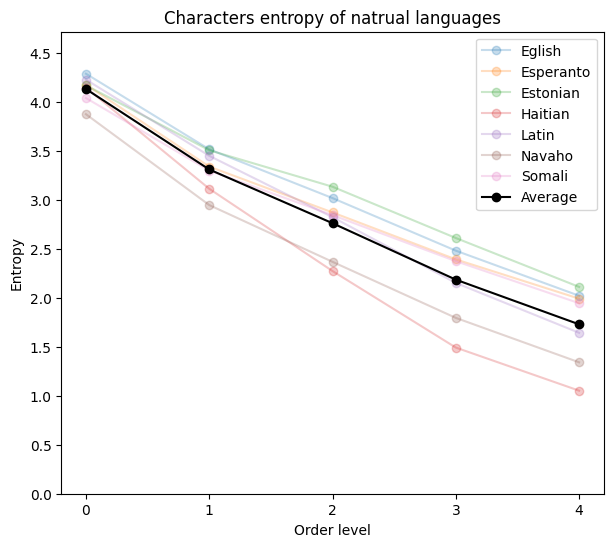

In [8]:
plt.figure(figsize=(7, 6))
zero_order_entropy = {}

for language in entropy.keys():
    entropies = list(entropy[language].values())
    zero_order_entropy[language] = entropies[0]
    plt.plot(entropies, marker="o", alpha=0.25)

plt.plot(averaged, c="k", marker="o")
plt.xlabel("Order level")
plt.ylabel("Entropy")
plt.title("Characters entropy of natrual languages")
plt.xticks(np.arange(5))
plt.yticks(np.arange(0, 4.51, 0.5))
plt.ylim(0, max(zero_order_entropy.values())*1.1)
plt.legend([translate[lng] for lng in list(zero_order_entropy.keys())] + ["Average"])
plt.show()

# Characters entropy of sample texts

In [ ]:
sample_entropy = {}
for sample in tqdm(os.listdir("./data/samples")):
    file_path = f"./data/samples/{sample}"
    base_name = sample.rstrip(".txt")
    sample_entropy[base_name] = {f"{i}_order_level":LanguageDetection(file_path, i).entropy for i in range(5)}

with open("./data/entropies/samples_entropy.json", "w") as f:
    json.dump(sample_entropy, f, indent=4)

100%|██████████| 6/6 [16:31<00:00, 165.30s/it]


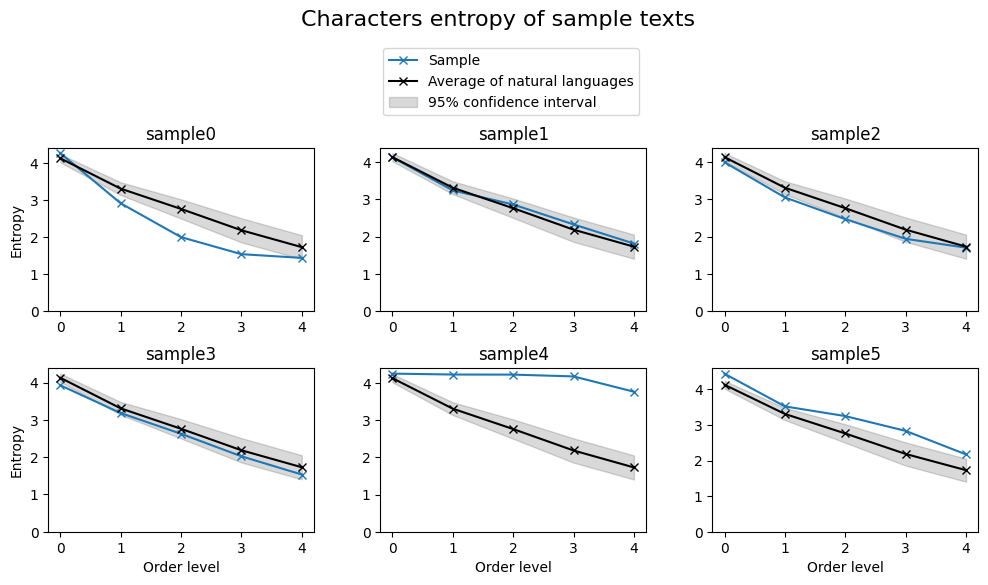

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for r in range(2):
    for c in range(3):
        sample_name = f"sample{r*3+c}"
        values = list(sample_entropy[sample_name].values())
        ax[r][c].plot(values, marker="x")
        ax[r][c].plot(averaged, c="k", marker="x")
        ax[r][c].fill_between(
            np.arange(5),
            [avg - ci for avg, ci in zip(averaged, confidence_intervals)],
            [avg + ci for avg, ci in zip(averaged, confidence_intervals)],
            color="k", alpha=0.15
        )
        ax[r][c].set_title(sample_name)
        ax[r][c].set_yticks(np.arange(0, 4.01))
        if c == 0:
            ax[r][c].set_ylabel("Entropy")
        if r == 1:
            ax[r][c].set_xlabel("Order level")

plt.legend(["Sample", "Average of natural languages", "95% confidence interval"], bbox_to_anchor=(-0.25, 3))
plt.subplots_adjust(wspace=0.25, hspace=0.35, top=0.75)
fig.suptitle("Characters entropy of sample texts", fontsize=16)
plt.show()

# Words entropy of languages from Wikipedia

In [ ]:
words_entropy = {}
for language in tqdm(translate.keys()):
    file = f"./data/wiki/norm_wiki_{language}.txt"
    words_entropy[language] = {f"{i}_order_level":LanguageDetection(file, i, words=True).entropy for i in range(5)}

with open("./data/entropies/natural_language_words_entropy.json", "w") as f:
    json.dump(words_entropy, f, indent=4)

100%|██████████| 7/7 [03:31<00:00, 30.21s/it]


In [39]:
words_averaged = {f"{i}_order_level": 0 for i in range(5)}
for language in words_entropy.keys():
    entropies = list(words_entropy[language].values())
    for i in range(len(entropies)):
        words_averaged[f"{i}_order_level"] += entropies[i]
words_averaged = [avg/len(words_entropy) for avg in words_averaged.values()]

words_confidence_intervals = {f"{i}_order_level": 0 for i in range(5)}
for language in words_entropy.keys():
    entropies = list(words_entropy[language].values())
    for i in range(len(entropies)):
        words_confidence_intervals[f"{i}_order_level"] += (words_averaged[i] - entropies[i])**2
words_confidence_intervals = [1.65*(sqr_sum/5)**0.5/5**0.5 for sqr_sum in words_confidence_intervals.values()]

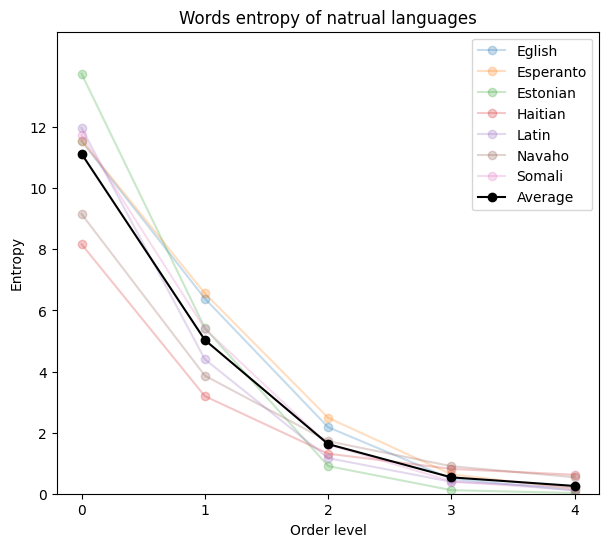

In [44]:
plt.figure(figsize=(7, 6))
words_zero_order_entropy = {}

for language in words_entropy.keys():
    entropies = list(words_entropy[language].values())
    words_zero_order_entropy[language] = entropies[0]
    plt.plot(entropies, marker="o", alpha=0.25)

plt.plot(words_averaged, c="k", marker="o")
plt.xlabel("Order level")
plt.ylabel("Entropy")
plt.title("Words entropy of natrual languages")
plt.xticks(np.arange(5))
plt.yticks(np.arange(0, 14, 2))
plt.ylim(0, max(words_zero_order_entropy.values())*1.1)
plt.legend([translate[lng] for lng in list(words_zero_order_entropy.keys())] + ["Average"])
plt.show()

# Words entropy of sample texts

In [36]:
words_sample_entropy = {}
for sample in tqdm(os.listdir("./data/samples")):
    file_path = f"./data/samples/{sample}"
    base_name = sample.rstrip(".txt")
    words_sample_entropy[base_name] = {f"{i}_order_level":LanguageDetection(file_path, i, words=True).entropy for i in range(5)}

with open("./data/entropies/samples_words_entropy.json", "w") as f:
    json.dump(words_sample_entropy, f, indent=4)

100%|██████████| 6/6 [02:21<00:00, 23.65s/it]


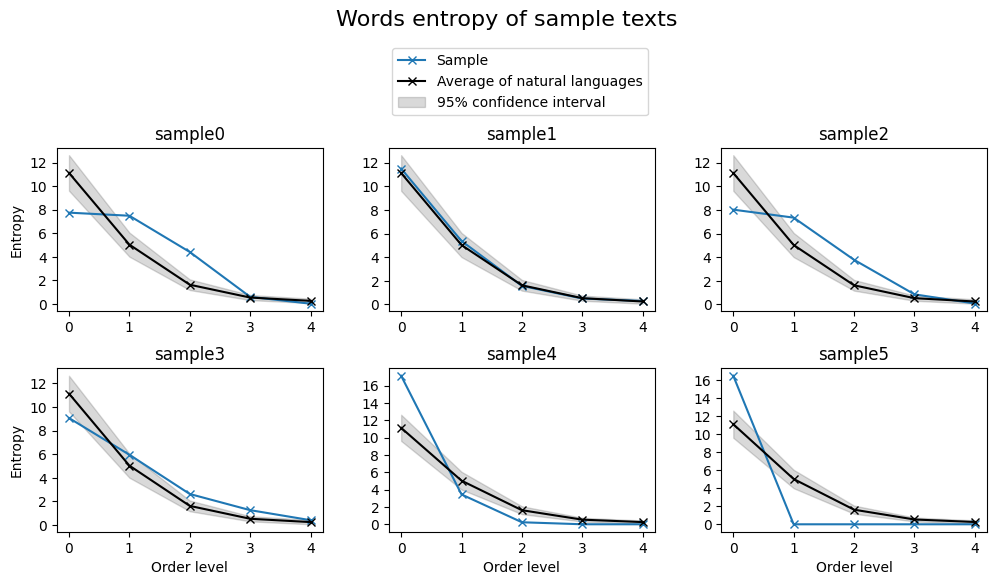

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for r in range(2):
    for c in range(3):
        sample_name = f"sample{r*3+c}"
        values = list(words_sample_entropy[sample_name].values())
        ax[r][c].plot(values, marker="x")
        ax[r][c].plot(words_averaged, c="k", marker="x")
        ax[r][c].fill_between(
            np.arange(5),
            [avg - ci for avg, ci in zip(words_averaged, words_confidence_intervals)],
            [avg + ci for avg, ci in zip(words_averaged, words_confidence_intervals)],
            color="k", alpha=0.15
        )
        ax[r][c].set_title(sample_name)
        ax[r][c].set_yticks(np.arange(0, 16.1 if (r, c) in [(1, 1), (1, 2)] else 12.1, 2))
        if c == 0:
            ax[r][c].set_ylabel("Entropy")
        if r == 1:
            ax[r][c].set_xlabel("Order level")

plt.legend(["Sample", "Average of natural languages", "95% confidence interval"], bbox_to_anchor=(-0.25, 3))
plt.subplots_adjust(wspace=0.25, hspace=0.35, top=0.75)
fig.suptitle("Words entropy of sample texts", fontsize=16)
plt.show()

# My predictions about samples texts
<table>
  <tr align="center">
    <th>Sample</th>
    <th>Chracters 95% confidence interval</th>
    <th>Words 95% confidence interval</th>
    <th>Prediction</th>
  </tr>
  <tr align="center">
    <td>sample0</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">Not a language</td>
  </tr>
  <tr align="center">
    <td>sample1</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">fit</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">fit</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">Real language</td>
  </tr>
  <tr align="center">
    <td>sample2</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">Not a language</td>
  </tr>
  <tr align="center">
    <td>sample3</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">fit</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">fit</td>
    <td style="background-color:rgba(0, 255, 0, 0.25);">Real language</td>
  </tr>
  <tr align="center">
    <td>sample4</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">Not a language</td>
  </tr>
  <tr align="center">
    <td>sample5</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">doesn't fit</td>
    <td style="background-color:rgba(255, 0, 0, 0.25);">Not a language</td>
  </tr>
</table>